In [7]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.stats import f

mpl.rcParams.update(mpl.rcParamsDefault)
#import itertools
def l_0_norm(vector):
    count = 0
    total = 0
    for element in vector:
        for sub_element in element:
            if sub_element != 0:
                count += 1
    return count
def take_average(dict):
    data = dict["0"]
    iterations_block = list(["0","1","2","3","4"])
    iterations_channel = list(["0","1","2","3","4"])
    for style , iterations in zip (["block","channel","block_random","channel_random"],[iterations_block,iterations_channel,iterations_block,iterations_channel]):
        for iter in iterations:
            if iter == "0":
                continue
            for norm in dict[iter]:
                for ratio in dict[iter][norm][style]:
                    for dataset in dict[iter][norm][style][ratio]:
                        value = np.array(dict[iter][norm][style][ratio][dataset])
                        data[norm][style][ratio][dataset] = (np.array(data[norm][style][ratio][dataset])+value)
                        if iter == iterations[-1]:
                            data[norm][style][ratio][dataset] = data[norm][style][ratio][dataset]/len(iterations)
                        #if norm == "|W|_0":
                            #    print(iter,style,ratio, dataset, np.linalg.norm(value,2))
    return data
def strip(name):
    name = name.split("/")[-1]
    name = name.split("_")[0]
    return name 
with open("result/all_distribution_new.json", 'r') as openfile:
    # Reading from json file
    all_distribution = json.load(openfile)
with open("result/distribution_7b.json", 'r') as openfile:
    # Reading from json file
    new_distribution = json.load(openfile)
def loop_over(dict):
    if isinstance(dict, list):
        print("end")
    else: 
        print(dict.keys())
        for keys in dict:
            loop_over(dict[keys])
def get_dataset_list(dataset_list):
    dataname = []
    for data in dataset_list:
        if "subset" not in dataset_list[data].keys():
            dataname.append(data)
        else:
            for subset in dataset_list[data]["subset"]:
                dataname.append(subset)
    return dataname
#Dataset List
with open("/home/bhandk/MLNeuron/dataset_info.json", 'r') as openfile:
        # Reading from json file
        dataset_list = json.load(openfile)
dataset_list = get_dataset_list(dataset_list)
new_distribution = take_average(new_distribution)


# LLM-PRUNER

## Compare two different pruned models

<Figure size 640x480 with 0 Axes>

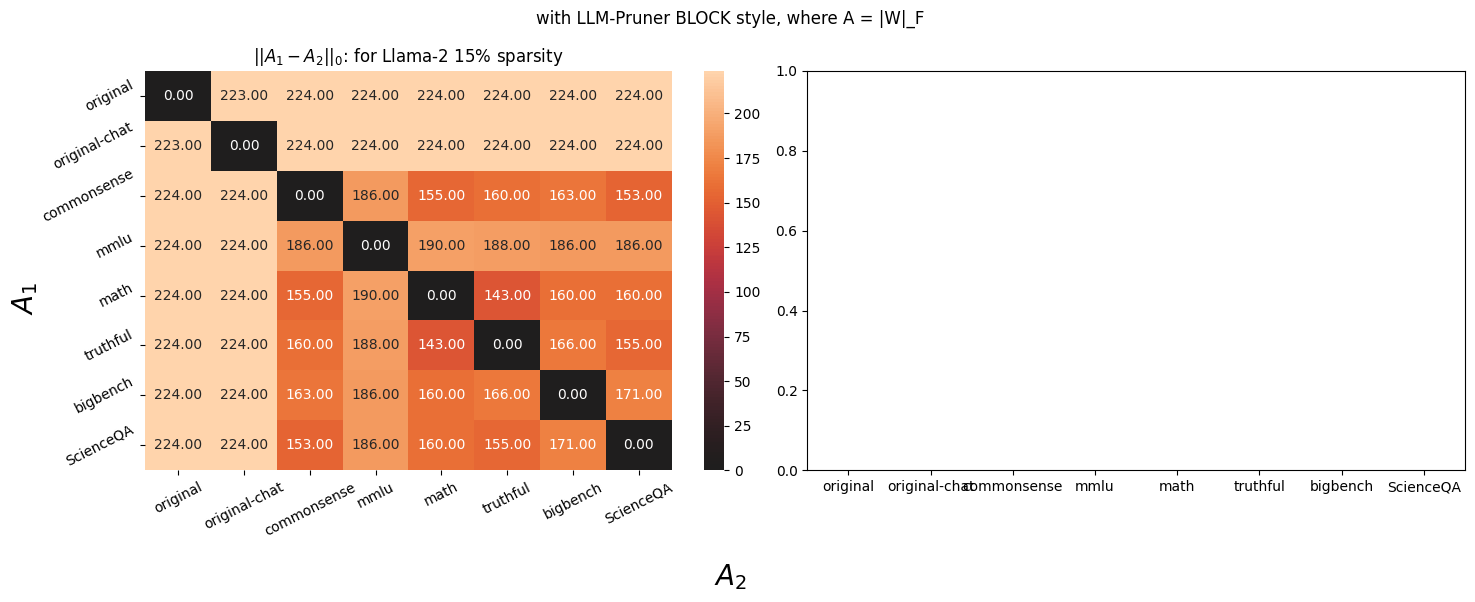

In [2]:
module = "|W|_F"
style = "block"
sparsity_model = {"5":["5","5-chat"],"15":["15","15-chat"],"25":["25","25-chat"]}
sparsity_model = {"15":["15"]}
plt.clf()
original = all_distribution[module]["original"]
original_chat = all_distribution[module]["original-chat"]
#llm_pruner =  all_distribution[module]["LLM_Pruner"]
llm_pruner =  new_distribution[module]
for sparsity in sparsity_model:
    sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
    for style in ["block"]:
        figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight", sharex=True)
        for  idx, ratio in enumerate(sparsity_model[sparsity]):
            data = []
            #dataset = ["original","original-chat","commonsense_qa","tasksource/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]
            dataset = ["original","original-chat","commonsense_qa","tasksource/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]
            for dataset_name in dataset:
                dataset_name = dataset_name.split('/')[-1]
                if dataset_name == "original" or dataset_name == "original-chat":
                    data.append((dataset_name,np.array(all_distribution[module][dataset_name])))
                else:
                    data.append((strip(dataset_name),np.array(llm_pruner[style][ratio][dataset_name])))    
            

            #permutation = list(itertools.permutations(data, 2))
            difference = []
            label = []
            for (d1,arr1) in data:
                values = []
                for (d2,arr2) in data:
                    M = l_0_norm(np.subtract(arr1,arr2)) #np.linalg.norm(np.subtract(arr1,arr2),2) #
                    values.append(M)
                label.append(d1)
                difference.append(values)
            axis[idx].set_title(r"$||A_1 - A_2||_0$"+f": for Llama-2 {ratio}% sparsity ")
            g = sns.heatmap(np.array(difference),  annot=True, fmt=".2f",center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=label,yticklabels=label)
            g.set_yticklabels(g.get_yticklabels(), rotation = 27)
            g.set_xticklabels(g.get_xticklabels(), rotation = 27)
        figure.supylabel(r"$A_1$", fontsize=20)
        figure.supxlabel(r"$A_2$", fontsize=20)
        figure.suptitle(f"with LLM-Pruner {style.upper()} style, where A = {module}")
        plt.savefig(f"result/distribution/llm_pruner_{style}_{sparsity}_compare.png")
        plt.show()

KeyError: 'commonsense_qa'

<Figure size 640x480 with 0 Axes>

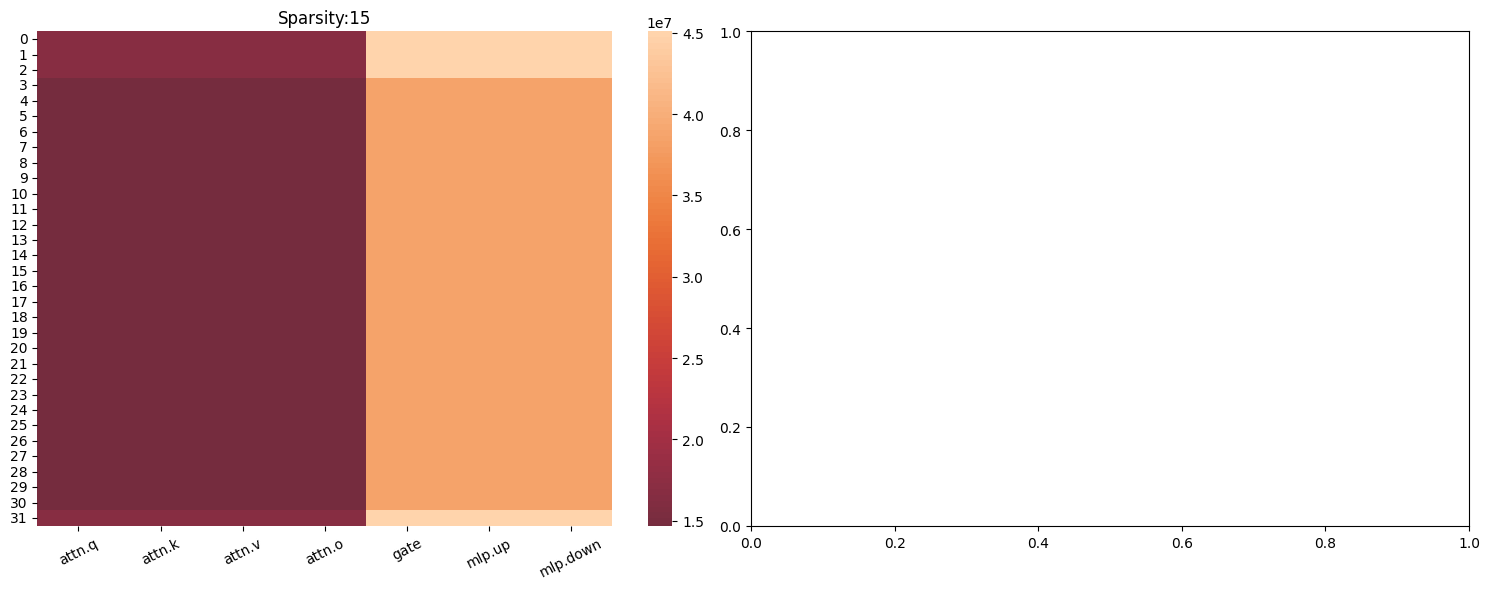

In [3]:
module = "|W|_0"
original = all_distribution[module]["original"]
original_chat = all_distribution[module]["original-chat"]
llm_pruner =  all_distribution[module]["LLM_Pruner"]
llm_pruner =  new_distribution[module]
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
ratio_list = ["15","15-chat"]
plt.clf()
for style in ["block", "channel"]:
    #for dataset in ["commonsense_qa","tasksource/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]:
    for dataset in ["commonsense_qa","tasksource/mmlu","math_qa","derek-thomas/ScienceQA"]:
        dataset_name = dataset.split('/')[-1]
        figure, axis = plt.subplots(ncols=len(ratio_list),figsize=(15, 6),layout="tight")
        #for idx,ratio in enumerate(["5","5-chat","15","15-chat","25","25-chat"]):
        for idx,ratio in enumerate(ratio_list):
            if not(ratio in llm_pruner[style].keys()):
                print(ratio,style,dataset_name)
                continue 
            if ratio.split("-")[-1] == "chat":
                difference = np.subtract(original_chat,llm_pruner[style][ratio][dataset_name])
                difference = llm_pruner[style][ratio][dataset_name]
            else:
                difference = np.subtract(original,llm_pruner[style][ratio][dataset_name])
                difference = llm_pruner[style][ratio][dataset_name]
            g = sns.heatmap(difference, center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=sub_layer)
            g.set_xticklabels(g.get_xticklabels(), rotation = 27)
            axis[idx].set_title(f"Sparsity:{ratio}")
        if module == "|W|_F":
            figure.suptitle(r"Difference in $|W|_F$ value of pruned model with LLM-Pruner "+ style +" : "+dataset_name.split('/')[-1])
        else:
            figure.suptitle(r"Difference in $|W|_0$ value of pruned model with LLM-Pruner "+ style +" : "+dataset_name.split('/')[-1])
        #plt.savefig(f"result/distribution/llm_pruner_{style}_{dataset_name.split('/')[-1]}.png")
        plt.show()
#permutation = list(itertools.permutations(data, 2))

# Albation

block


KeyError: 'commonsense_qa'

<Figure size 640x480 with 0 Axes>

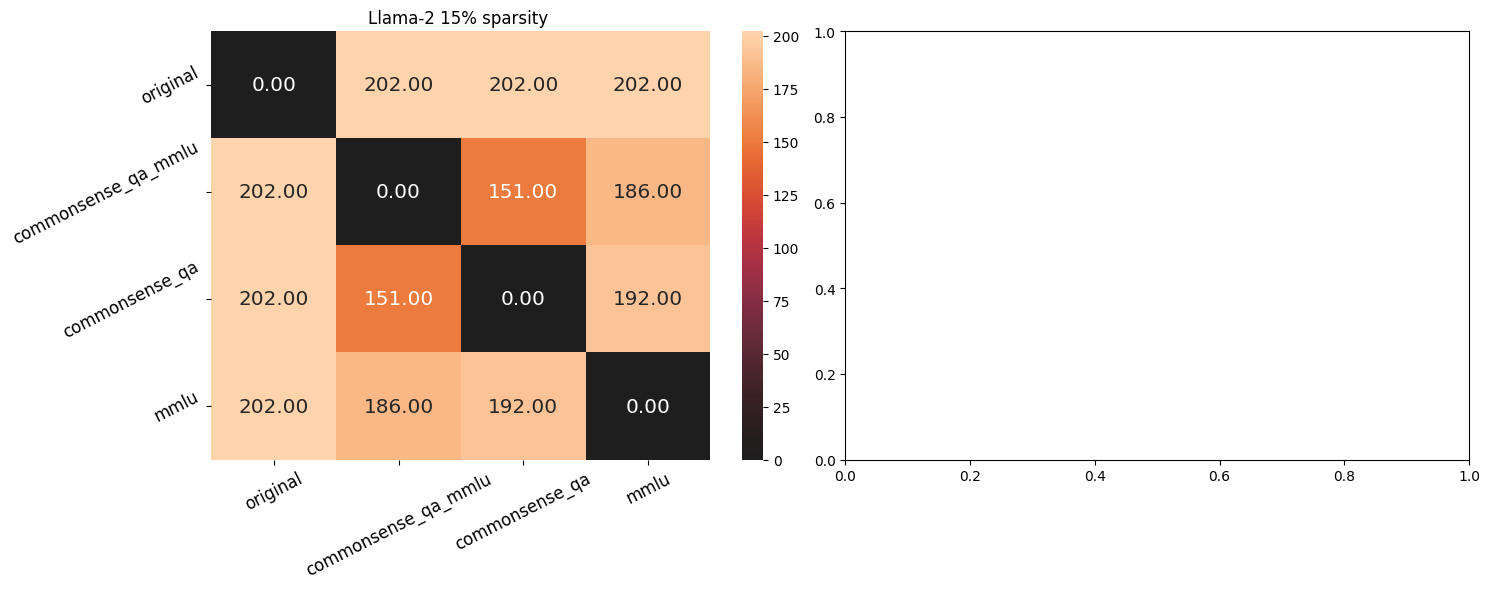

In [4]:
dataset_both = [["commonsense_qa","tasksource/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","EleutherAI/truthful_qa_mc"],["commonsense_qa","derek-thomas/ScienceQA"],["tasksource/mmlu","derek-thomas/ScienceQA"]]
dataset_both = [["commonsense_qa","tasksource/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","derek-thomas/ScienceQA"],["math_qa","derek-thomas/ScienceQA"]]
module = "|W|_0"
style = "block"
sparsity_model = {"5":["5","5-chat"],"15":["15","15-chat"]}
sparsity_model = {"15":["15","15-chat"]}
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
plt.clf()
original = all_distribution[module]["original"]
original_chat = all_distribution[module]["original-chat"]
#llm_pruner =  all_distribution[module]["LLM_Pruner"]
llm_pruner =  new_distribution[module]
for sparsity in sparsity_model:
    for style in ["block"]:
        print(style)
        for dataset_combine in dataset_both:
            figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight")
            for ratio_idx, ratio in enumerate(sparsity_model[sparsity]):
                newFolder = "_".join([d.split('/')[-1] for d in dataset_combine])
                if ratio.split("-")[-1] == "chat":  
                    original = "original-chat"
                else:
                    original = "original"
                dataset_name = [original, newFolder,dataset_combine[0],dataset_combine[1]]
                data = []
                idx = 0
                #figure, axis = plt.subplots(ncols=3,figsize=(15, 6),layout="tight")
                mix = np.array(all_distribution[module][original])
                for dataset in dataset_name:
                    dataset = dataset.split('/')[-1]
                    if dataset == "original" or dataset == "original-chat" :
                        data.append((dataset,np.array(all_distribution[module][dataset])))
                    else:
                        data.append((dataset,np.array(llm_pruner[style][ratio][dataset]))) 
                        diff = np.subtract(mix,data[-1][1])
                difference = []
                label = []
                for (d1,arr1) in data:
                    values = []
                    for (d2,arr2) in data:
                        M = l_0_norm(arr1-arr2)  #np.linalg.norm(arr1 - arr2,2) #
                        values.append(M) 
                    label.append(d1)
                    difference.append(values)
                if ratio.split("-")[-1] == "chat":
                    axis[ratio_idx].set_title(f"Llama-2-Chat {ratio}% sparsity ")
                else:
                    axis[ratio_idx].set_title(f"Llama-2 {ratio}% sparsity ")
                g = sns.heatmap(np.array(difference),  annot=True, fmt=".2f",center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[ratio_idx],xticklabels=label,yticklabels=label,annot_kws={"fontsize" : "x-large"})
                g.set_yticklabels(g.get_yticklabels(), rotation = 27,fontsize ="large")
                g.set_xticklabels(g.get_xticklabels(), rotation = 27,fontsize ="large")
            figure.suptitle(f"{style.upper()}: "+r"$||A_1 - A_2||_0$"+f" with {ratio.split('-')[0]}% sparsity")
            figure.supylabel(r"$A_1$", fontsize=20)
            figure.supxlabel(r"$A_2$", fontsize=20)
            #plt.savefig(f"result/distribution/albation_{style}_{ratio}_{newFolder}.png")
            plt.show()


## Albation compare architecture

In [ ]:
dataset_both = [["commonsense_qa","tasksource/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","EleutherAI/truthful_qa_mc"],["commonsense_qa","derek-thomas/ScienceQA"],["tasksource/mmlu","derek-thomas/ScienceQA"]]
#dataset_both = [["commonsense_qa","tasksource/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","derek-thomas/ScienceQA"]]
dataset_both = [["commonsense_qa","tasksource/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","derek-thomas/ScienceQA"],["math_qa","derek-thomas/ScienceQA"]]
module = "|W|_0"
style = "block"
sparsity_model = {"5":["5","5-chat"],"15":["15","15-chat"]}
sparsity_model = {"15":["15"]}
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
plt.clf()
original = all_distribution[module]["original"]
original_chat = all_distribution[module]["original-chat"]
#llm_pruner =  all_distribution[module]["LLM_Pruner"]
llm_pruner =  new_distribution[module]#["LLM_Pruner"]
for sparsity in sparsity_model:
    for style in ["block", "channel"]:
        print(style)
        for dataset_combine in dataset_both:
            for ratio_idx, ratio in enumerate(sparsity_model[sparsity]):
                print(f"\t {ratio}")
                figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight")
                newFolder = "_".join([d.split('/')[-1] for d in dataset_combine])
                dataset_name = [dataset_combine[0],dataset_combine[1]]
                mix = np.array(llm_pruner[style][ratio][newFolder])
                for idx,dataset in enumerate(dataset_name):
                    dataset = dataset.split('/')[-1]
                    diff = np.subtract(mix,np.array(llm_pruner[style][ratio][dataset]))
                    g = sns.heatmap(diff, center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=sub_layer)
                    g.set_xticklabels(g.get_xticklabels(), rotation = 27)
                    axis[idx].set_title(f"{dataset}")
                if ratio.split('-')[-1] == "chat":
                    figure.suptitle(r"Difference in $|W|_0$ value of Llama-2-chat "+ sparsity +"% pruned model: "+ newFolder)
                else:
                    figure.suptitle(r"Difference in $|W|_0$ value of Llama-2 "+ sparsity +"% pruned model: "+ newFolder)
                figure.tight_layout()
                #plt.savefig(f"result/distribution/albation_architecture_{ratio}_{newFolder}.png")
                plt.show()
                plt.clf()

# PCA and t-SNE comparison

## All Flatten to a single layer and use KMeans for cluster

In [8]:
def visualize(number_cluster, all_data,X_pca,clusters_pca,random_pca=[]):
        cmap = plt.cm.tab20  # define the colormap
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # force the first color entry to be grey
        cmaplist[0] = (.5, .5, .5, 1.0)

        # create the new map
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap.N)

        # define the bins and normalize
        bounds = np.linspace(0, number_cluster,number_cluster+1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)



        indexes_pca = [(x,np.where(clusters_pca == x)[0]) for x in set(clusters_pca)]
        lw = 2
        figure, axis = plt.subplots(figsize=(8, 6))
        if len(random_pca) != 0:
            axis.scatter(random_pca[:, 0],  random_pca[:, 1], color = "black",label="Random")
        axis.scatter(X_pca[:, 0],  X_pca[:, 1], c=clusters_pca,
                  cmap=cmap, norm=norm,alpha=.8, lw=lw)
        #axis[1].scatter(X_tsne[1:, 0],X_tsne[1:, 1], c=clusters_tsne[1:],cmap=cmap, norm=norm,alpha=.8, lw=lw)
        
        #ax2 = figure.add_axes([0.95, 0.1, 0.03, 0.8])
        ax2 = figure.add_axes([0.99, 0.1, 0.03, 0.8])
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

        axis.set_title(f"PCA")

        figure.suptitle(f" Pruned with {style} strategy with ratio {ratio} and {module} norm for {number_cluster} clusters")
        for cluster, index in indexes_pca:
            axis.annotate(all_data[index[0]], (X_pca[index[0],0], X_pca[index[0],1]))
            try:
                axis.annotate(all_data[index[1]], (X_pca[index[1],0], X_pca[index[1],1]))
            except:
                continue
        axis.axhline(0)
        axis.axvline(0)
        axis.legend()
        print("pca")
        for cluster, indexes  in indexes_pca:
            print(cluster)
            print([all_data[i] for i in indexes])
        #sfig2.delaxes(ax3)
        #fig2.delaxes(ax4)
        plt.show()

# Statistical testing

In [36]:

def hotelling_t2_test(data_A, data_B):
    # Calculate mean and covariance matrices for each dataset
    mean_A = np.mean(data_A, axis=0)
    mean_B = np.mean(data_B, axis=0)

    cov_A = np.cov(data_A, rowvar=False)
    cov_B = np.cov(data_B, rowvar=False)

    # Number of samples in each dataset
    n_A = len(data_A)
    n_B = len(data_B)

    # Pooled covariance matrix
    pooled_cov = ((n_A - 1) * cov_A + (n_B - 1) * cov_B) / (n_A + n_B - 2)

    # Calculate the T-squared statistic
    t_squared = n_A * n_B / (n_A + n_B) * np.dot(np.dot((mean_A - mean_B).T, np.linalg.inv(pooled_cov)), (mean_A - mean_B))

    # Degrees of freedom for the F-distribution
    df1 = data_A.shape[1]
    df2 = n_A + n_B - data_A.shape[1] - 1

    # p-value from the F-distribution
    p_value = 1 - f.cdf(t_squared * (n_A + n_B - 2) / (n_A * df1), df1, df2)

    return t_squared, p_value
def hotelling_t2_test_clusters(X, clusters):
    # Identify unique clusters
    unique_clusters = np.unique(clusters)

    # Perform Hotelling's T-squared test for each pair of clusters
    data = np.zeros((len(unique_clusters),len(unique_clusters)))
    save_p_value = []
    save_mean_value = []
    for i in range(len(unique_clusters)):
        p_value_list = []
        mean_value_list = []
        for j in range(0, len(unique_clusters)):
            if j <= i:
                p_value_list.append(0)
                mean_value_list.append(0)
                continue
            # Extract data for each cluster
            cluster_i_data = X[clusters == unique_clusters[i],:]
            cluster_j_data = X[clusters == unique_clusters[j],:]
            # Perform Hotelling's T-squared test
            t_squared_stat, p_value = hotelling_t2_test(cluster_i_data, cluster_j_data)
            # Output results
            #print(f"Comparison between Cluster {unique_clusters[i]} and Cluster {unique_clusters[j]}:")
            #print("Hotelling's T-squared Statistic:", t_squared_stat)
            #print("P-value:", p_value)
            #print()
            p_value_list.append(p_value)
            mean_value_list.append(t_squared_stat)
        save_p_value.append(p_value_list)
        save_mean_value.append(mean_value_list)
    print(unique_clusters)
    figure, axis = plt.subplots(figsize=(12, 6), ncols=2)
    p_value = np.array(save_p_value)
    mean_value = np.array(save_mean_value)
    if len(unique_clusters) == 4:
        labels=["grey","pink","blue","black"]
    else:
        labels=["grey","red","pink","blue","black"]
    sns.heatmap(p_value, annot=True, ax=axis[1],xticklabels=labels, yticklabels=labels)
    axis[1].set_title("P-value")
    print("Here")
    sns.heatmap(mean_value, annot=True, ax=axis[0],xticklabels=labels, yticklabels=labels)
    axis[0].set_title("Statistics")
    figure.suptitle(f"Hotelling's T-squared Statistic")

    plt.plot()


PCA: CLUSTERS 3 0.6539874810994822
Computing statistical testing
[0 1 2 3]
Here
Hotelling's T-squared Statistic: 2773.963047529689
P-value: 1.1102230246251565e-16
pca
0
['abstract_narrative_understanding', 'arithmetic', 'bbq_lite_json', 'causal_judgment', 'code_line_description', 'color', 'conceptual_combinations', 'crash_blossom', 'crass_ai', 'dark_humor_detection', 'date_understanding', 'disambiguation_qa', 'elementary_math_qa', 'emoji_movie', 'empirical_judgments', 'english_proverbs', 'english_russian_proverbs', 'epistemic_reasoning', 'evaluating_information_essentiality', 'fantasy_reasoning', 'figure_of_speech_detection', 'formal_fallacies_syllogisms_negation', 'general_knowledge', 'geometric_shapes', 'goal_step_wikihow', 'hhh_alignment', 'identify_odd_metaphor', 'implicit_relations', 'intent_recognition', 'international_phonetic_alphabet_nli', 'irony_identification', 'language_identification', 'logic_grid_puzzle', 'logical_args', 'logical_deduction', 'logical_sequence', 'metaphor_

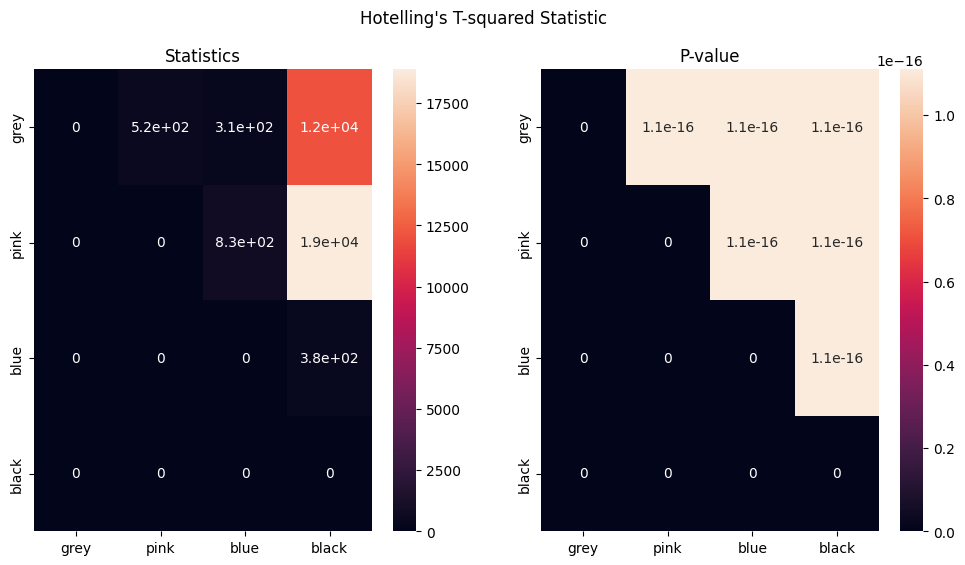

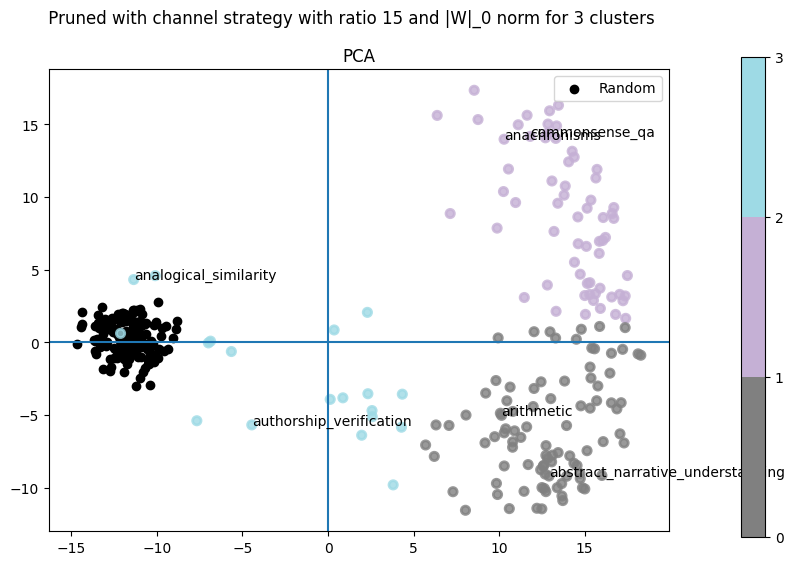

PCA: CLUSTERS 4 0.6145915477997022
Computing statistical testing
[0 1 2 3 4]
Here
Hotelling's T-squared Statistic: 2773.963047529689
P-value: 1.1102230246251565e-16
pca
0
['abstract_narrative_understanding', 'arithmetic', 'bbq_lite_json', 'causal_judgment', 'code_line_description', 'color', 'conceptual_combinations', 'crass_ai', 'dark_humor_detection', 'date_understanding', 'disambiguation_qa', 'elementary_math_qa', 'emoji_movie', 'empirical_judgments', 'english_proverbs', 'english_russian_proverbs', 'epistemic_reasoning', 'evaluating_information_essentiality', 'fantasy_reasoning', 'figure_of_speech_detection', 'formal_fallacies_syllogisms_negation', 'geometric_shapes', 'goal_step_wikihow', 'hhh_alignment', 'identify_odd_metaphor', 'implicit_relations', 'intent_recognition', 'international_phonetic_alphabet_nli', 'language_identification', 'logic_grid_puzzle', 'logical_args', 'logical_deduction', 'logical_sequence', 'metaphor_understanding', 'moral_permissibility', 'movie_dialog_same_o

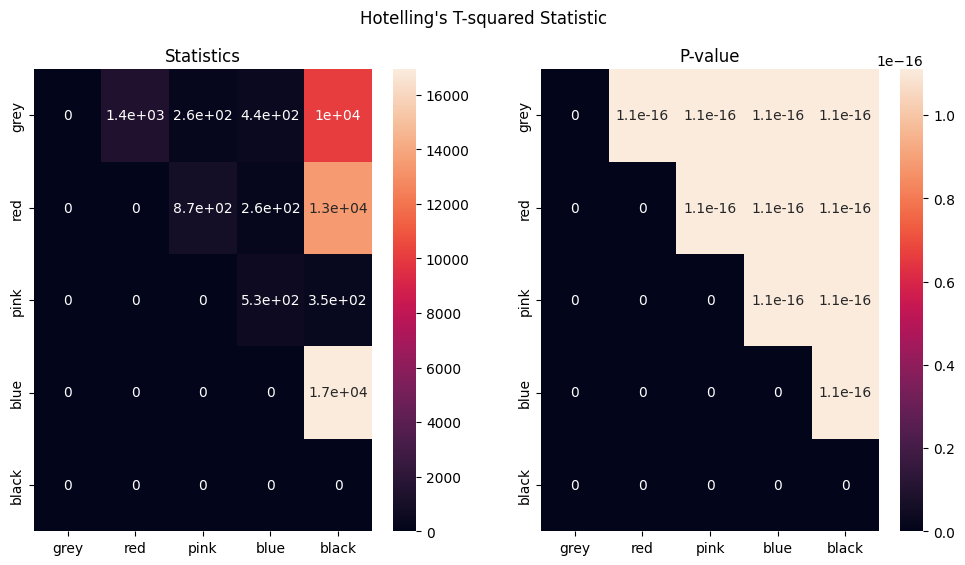

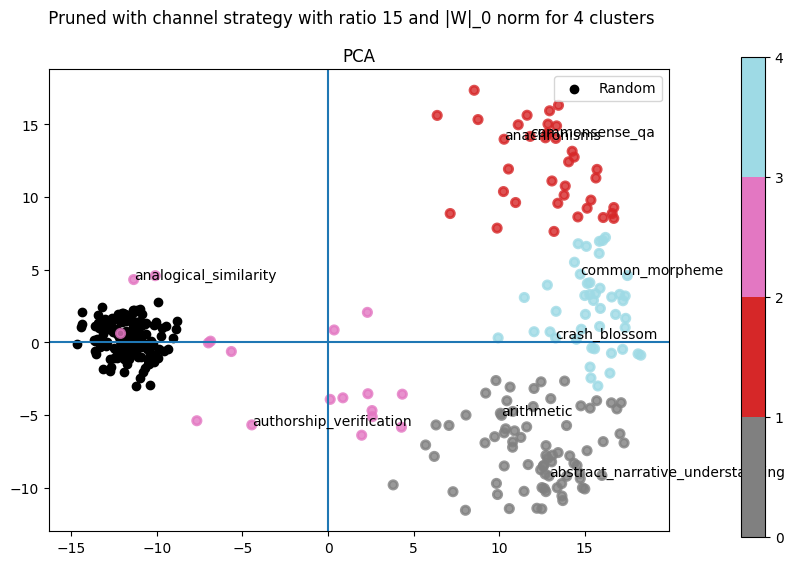

PCA: CLUSTERS 3 0.7291004218093834
Computing statistical testing
[0 1 2 3]
Here
Hotelling's T-squared Statistic: 3396.7754337752644
P-value: 1.1102230246251565e-16
pca
0
['arithmetic', 'bbq_lite_json', 'causal_judgment', 'code_line_description', 'color', 'common_morpheme', 'conceptual_combinations', 'crass_ai', 'cryobiology_spanish', 'dark_humor_detection', 'date_understanding', 'disambiguation_qa', 'elementary_math_qa', 'emoji_movie', 'empirical_judgments', 'english_proverbs', 'english_russian_proverbs', 'epistemic_reasoning', 'evaluating_information_essentiality', 'fantasy_reasoning', 'figure_of_speech_detection', 'formal_fallacies_syllogisms_negation', 'general_knowledge', 'goal_step_wikihow', 'hindu_knowledge', 'identify_odd_metaphor', 'implicit_relations', 'intent_recognition', 'international_phonetic_alphabet_nli', 'irony_identification', 'key_value_maps', 'language_identification', 'logic_grid_puzzle', 'logical_args', 'logical_deduction', 'logical_sequence', 'metaphor_boolean', 

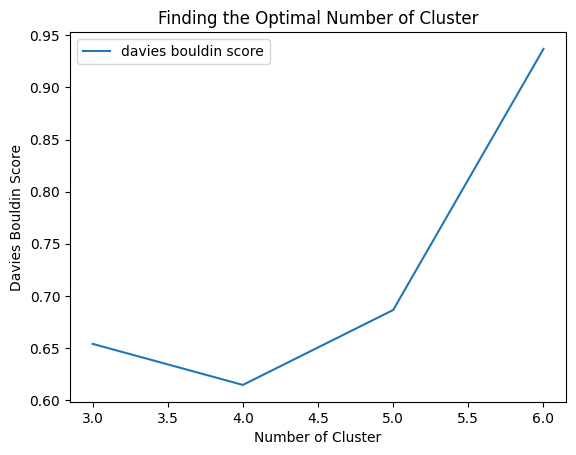

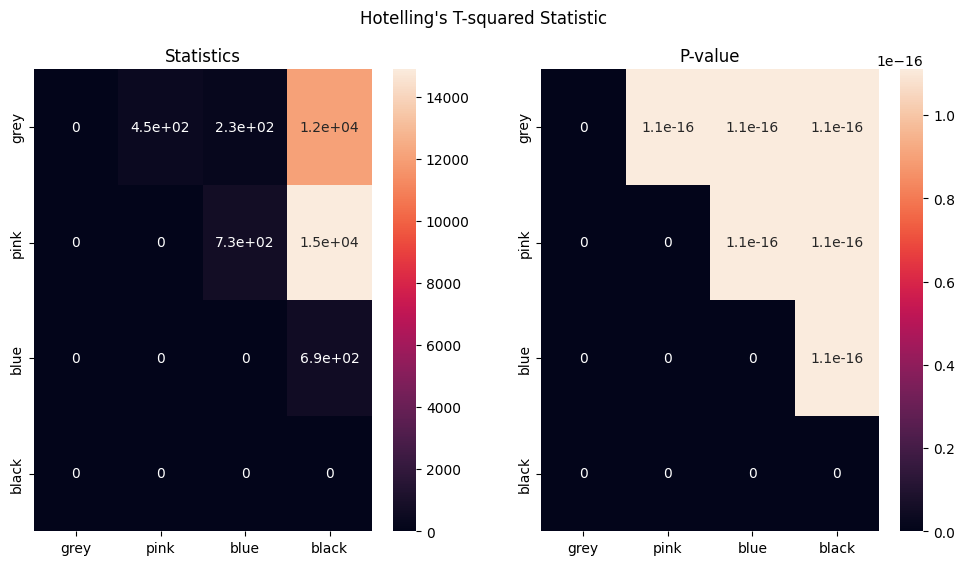

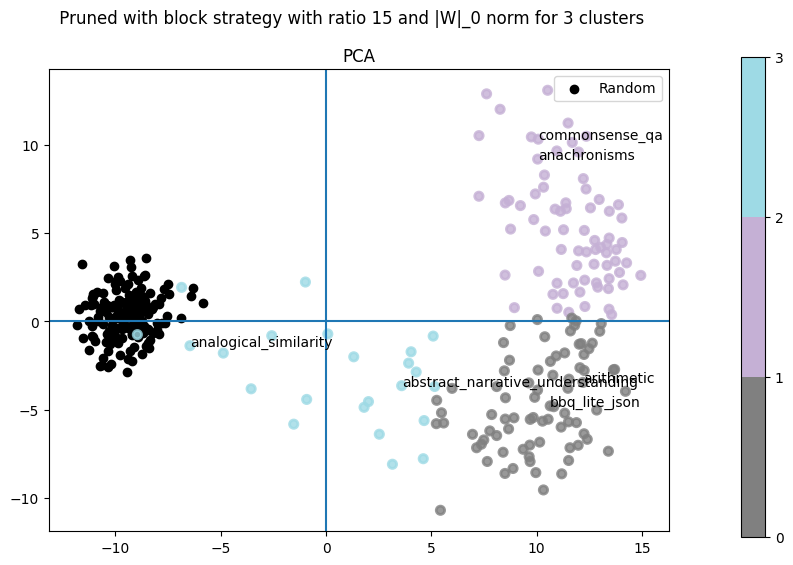

PCA: CLUSTERS 4 0.7178715467309132
Computing statistical testing
[0 1 2 3 4]
Here
Hotelling's T-squared Statistic: 3396.7754337752644
P-value: 1.1102230246251565e-16
pca
0
['arithmetic', 'code_line_description', 'common_morpheme', 'crash_blossom', 'cryobiology_spanish', 'dark_humor_detection', 'elementary_math_qa', 'fantasy_reasoning', 'general_knowledge', 'hhh_alignment', 'hindu_knowledge', 'human_organs_senses', 'implicatures', 'irony_identification', 'logical_fallacy_detection', 'mathematical_induction', 'metaphor_boolean', 'movie_recommendation', 'parsinlu_qa', 'phrase_relatedness', 'physical_intuition', 'reasoning_about_colored_objects', 'ruin_names', 'similarities_abstraction', 'snarks', 'social_iqa', 'social_support', 'winowhy', 'abstract_algebra', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_computer_science', 'college_medicine', 'college_physics', 'econometrics', 'elementary_mathematics', 'formal_logic', 'high_school_chemistry', 'high_school_computer_sc

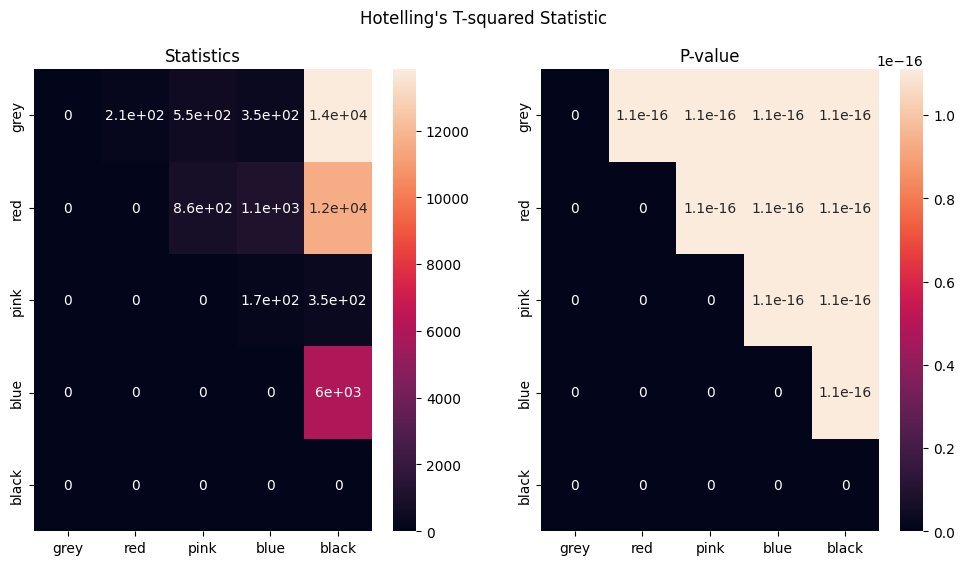

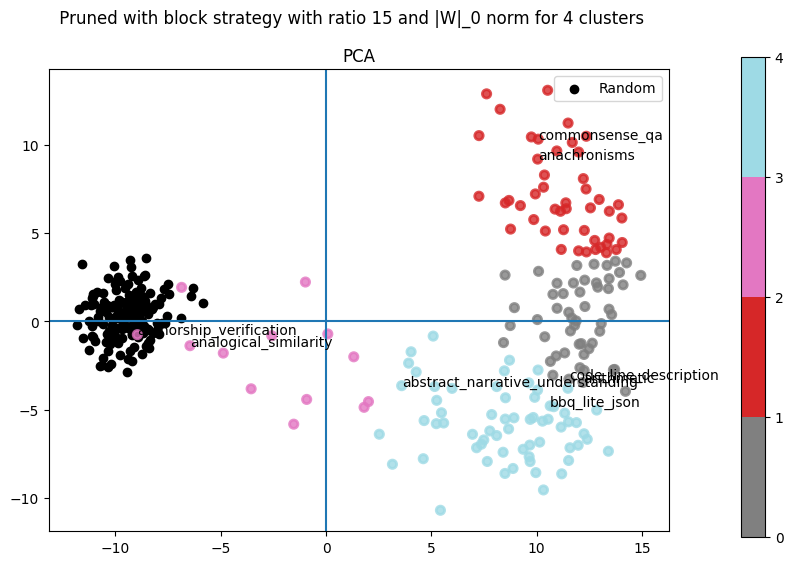

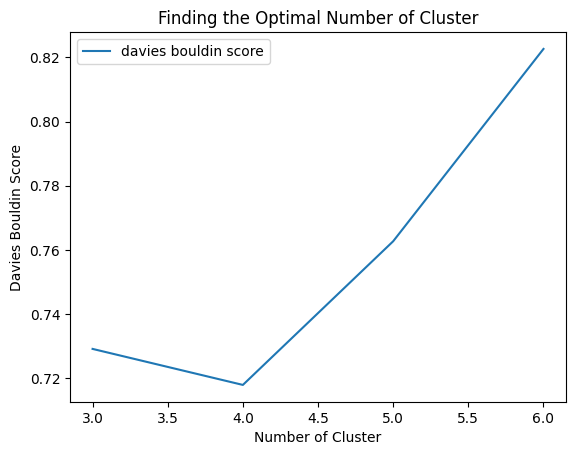

In [37]:
colors = ["pink",'navy', 'turquoise', 'orange', "green", "red" ,"grey","yellow","violet"]
layers = np.arange(0,32,1)#[3:31]
ratio = "15"
module = "|W|_0"
#for module in ["|W|_0","|W|_F"]:
for style in ["channel","block"]:
    best_idx_tsne = 10000
    best_idx_pca = 10000 
    store_pca= []
    store_cluster= []
    #for NUM_CLUSTER in [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
    for NUM_CLUSTER in [3,4,5,6]:
        #for NUM_CLUSTER in [5]:
        #llm_pruner =  all_distribution[module]["LLM_Pruner"]
        llm_pruner =  new_distribution[module]#["LLM_Pruner"]
        sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
        #for dataset in ["commonsense_qa","tasksource/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]:
        label = ["original","original-chat" ]
        if ratio.split("-")[-1] != "chat":  
            original = np.array(all_distribution[module]["original"])[layers,:]
        else:
            original = np.array(all_distribution[module]["original-chat"])[layers,:]
        label = [ ]
        label_idx = []
        all_data = dataset_list#["commonsense_qa","tasksource/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]
        #if "math_qa" in all_data:
        #    all_data.remove("math_qa")
        Random = []
        for idx, dataset_name in enumerate(all_data):
            dataset = dataset_name.split('/')[-1]
            label.append(dataset)
            label_idx.append(idx)
            if idx == 0:
                if dataset == "original":
                    X = original.flatten().reshape(-1,1).T
                else:
                    X_new = (np.array(llm_pruner[style][ratio][dataset])[layers,:])
                    X =  X_new.flatten().reshape(-1,1).T
                    #y = np.zeros(X_new.shape[0])
                    X_new =  np.array(llm_pruner[style+"_random"][ratio][dataset])[layers,:]
                    Random = X_new.flatten().reshape(-1,1).T
                continue
            X_new =  np.array(llm_pruner[style][ratio][dataset])[layers,:]
            X_new = X_new.flatten().reshape(-1,1).T
            X = np.append(X, X_new, axis=0)
            if len(Random) != 0:
                X_new =  np.array(llm_pruner[style+"_random"][ratio][dataset])[layers,:].flatten().reshape(-1,1).T
                Random = np.append(Random, X_new, axis=0)
            else:
                Random =  np.array(llm_pruner[style+"_random"][ratio][dataset])[layers,:].flatten().reshape(-1,1).T
        new_dataset = all_data +["random"] * len(Random)
        # Standardize the feature matrix (mean center and scale)
        scaler = StandardScaler()
        X_scaled = np.append(X, Random, axis=0)#X#scaler.fit_transform(X)
        # Perform PCA
        n_components = 2  # Number of components to keep
        kmeans = KMeans(n_init="auto",n_clusters=NUM_CLUSTER, random_state=0)  # KMEANS
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        #Random_pca = pca.fit_transform(Random)
        clusters_pca = kmeans.fit_predict(X_pca[:len(all_data),:])

        '''tsne = TSNE(n_components=n_components, random_state=42, method="exact")
        X_tsne = tsne.fit_transform(X_scaled)
        #Random_tsne = tsne.fit_transform(Random)
        clusters_tsne = kmeans.fit_predict(X_tsne)
        db_index_tsne = davies_bouldin_score(X_tsne, clusters_tsne)
         if db_index_tsne < best_idx_tsne:
            print("TSNE: CLUSTERS",NUM_CLUSTER, db_index_tsne)
            best_idx_tsne = db_index_tsne
            #visualize(NUM_CLUSTER, all_data,X_pca,clusters_pca,X_tsne,clusters_tsne)
        '''


        db_index_pca = davies_bouldin_score(X_pca[:len(all_data),:], clusters_pca)
        store_pca.append(db_index_pca)
        store_cluster.append(NUM_CLUSTER)
        
        if db_index_pca < best_idx_pca:
            print("PCA: CLUSTERS",NUM_CLUSTER ,db_index_pca)
            best_idx_pca = db_index_pca                
            print("Computing statistical testing")
            t_squared_stat, p_value = hotelling_t2_test(X_pca[:len(all_data),:], X_pca[len(all_data):-1,:])
            #hotelling_t2_test_clusters(X_pca[:len(all_data),:], clusters_pca)
            hotelling_t2_test_clusters(X_pca, np.append(clusters_pca,np.array([max(clusters_pca)+1]*len(Random))))
            print("Hotelling's T-squared Statistic:", t_squared_stat)
            print("P-value:", p_value)
            visualize(NUM_CLUSTER, new_dataset,X_pca[:len(all_data),:],clusters_pca, random_pca=X_pca[len(all_data):-1,:])
            print("="*100)
       
    plt.plot(store_cluster,store_pca, label="davies bouldin score")
    plt.xlabel("Number of Cluster")
    plt.ylabel("Davies Bouldin Score")
    plt.title("Finding the Optimal Number of Cluster")
    plt.legend()
    plt.plot()
    print("="*1000)


# Extra
## PCA and t-SNE for Mixed Model

In [ ]:
dataset_both = [["commonsense_qa","tasksource/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","derek-thomas/ScienceQA"],["math_qa","derek-thomas/ScienceQA"]]
layers = np.arange(0,32,1)[3:31]
module = "|W|_0"
ratio  = "15"
llm_pruner =  new_distribution[module]#["LLM_Pruner"]
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
style = "block"
original = np.array(all_distribution[module]["original"])[layers,:]
#for dataset in ["commonsense_qa","tasksource/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]:
for data in dataset_both:
    newFolder = "_".join([d.split('/')[-1] for d in data])
    X = original - np.array(llm_pruner[style][ratio][newFolder])[layers,:]
    #X = original
    y = np.zeros(X.shape[0])
    #X =np.append(X, np.array(llm_pruner[style][ratio][newFolder])[3:31,:], axis=0)
    #y = np.append(y, np.ones(X_new.shape[0]), axis=0)# Target
    label = [newFolder]
    for idx, dataset_name in enumerate(data):
        dataset = dataset_name.split('/')[-1]
        label.append(dataset)
        #X_new =  original - np.array(llm_pruner[style][ratio][dataset])#[3:31,:]
        X_new =  original -np.array(llm_pruner[style][ratio][dataset])[layers,:]
        X = np.append(X, X_new, axis=0)
        y_new = np.ones(X_new.shape[0])*(idx+1)
        y = np.append(y, y_new, axis=0)
    # Standardize the feature matrix (mean center and scale)
    scaler = StandardScaler()
    X_scaled = X#scaler.fit_transform(X)

    # Perform PCA
    n_components = 2  # Number of components to keep
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    tsne = TSNE(n_components=n_components, random_state=42, method="exact")
    X_tsne = tsne.fit_transform(X_scaled)
    # Explained variance ratio
    explained_variance_ratio_pca = pca.explained_variance_ratio_

    # Print the explained variance ratio
    print("Explained Variance Ratio:", explained_variance_ratio_pca)
    figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight")

    # Create a scatter plot of the data using the first two principal components
    colors = ['navy', 'turquoise', 'darkorange']
    # Create a scatter plot of the data using the first two principal components
    markers = ["^","X","o","+","v","^","P","D"]
    colors = [
        "#FF5733", "#33FF57", "#5733FF", "#FF33A6", "#33A6FF", "#A6FF33", "#FF8C33", "#338CFF",
        "#FF33FF", "#33FFB2", "#B233FF", "#33FF33", "#FF46A6", "#46A6FF", "#A6FF46", "#FF3333",
        "#33FF66", "#66FF33", "#FF33B2", "#B233FF", "#33B2FF", "#FF33FF", "#33FFA6", "#A6FF33",
        "#FF5733", "#33FF57", "#5733FF", "#FF33A6", "#33A6FF", "#A6FF33", "#FF8C33", "#338CFF",
    ]

    lw = 2
    #for color, i, target_name in zip(colors, np.arange(original.shape[0]), np.arange(original.shape[0])):
    for marker, i, target_name in zip(markers, label_idx, label):
        x_pca_0, x_pca_1 = X_pca[y == i, 0], X_pca[y == i, 1]
        x_tsne_0, x_tsne_1 = X_tsne[y == i, 0], X_tsne[y == i, 1]
        for idx, (color, layer) in enumerate(zip(colors,layers)):
            if layer == layers[-1]:
                axis[0].scatter(x_pca_0[idx], x_pca_1[idx], color=color,marker=marker, alpha=.8, lw=lw,
                        label=target_name)
                axis[1].scatter(x_tsne_0[idx],x_tsne_1[idx], color=color,marker=marker, alpha=.8, lw=lw,
                        label=target_name)
            else:
                axis[0].scatter(x_pca_0[idx], x_pca_1[idx], color=color,marker=marker, alpha=.8, lw=lw)
                axis[1].scatter(x_tsne_0[idx],x_tsne_1[idx], color=color,marker=marker, alpha=.8, lw=lw)
    axis[0].set_title(f"PCA")
    axis[1].set_title(f"t-SNE")
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    figure.suptitle(f"Dataset {data} with {style} pruning strategy for {ratio} ratio with {module} norm")
    plt.show()